<a href="https://colab.research.google.com/github/CamiRojas04/Microscopia_Optica_IO_Tercera_Entrega/blob/main/Campo_claro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Punto 2


In [3]:
!pip install cairosvg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.7 MB/s eta 0:00:00


Grupo imagen 1 (g_fisico=4): periodo = 1.096 µm, f ≈ 912.4 lp/mm
Grupo imagen 2 (g_fisico=5): periodo = 1.370 µm, f ≈ 729.9 lp/mm
Grupo imagen 3 (g_fisico=6): periodo = 1.644 µm, f ≈ 608.3 lp/mm
Grupo imagen 4 (g_fisico=7): periodo = 1.918 µm, f ≈ 521.4 lp/mm
Grupo imagen 5 (g_fisico=8): periodo = 2.192 µm, f ≈ 456.2 lp/mm
Grupo imagen 6 (g_fisico=9): periodo = 2.466 µm, f ≈ 405.5 lp/mm
Grupo imagen 7 (g_fisico=10): periodo = 2.740 µm, f ≈ 365.0 lp/mm
Grupo imagen 8 (g_fisico=11): periodo = 3.014 µm, f ≈ 331.8 lp/mm
Grupo imagen 9 (g_fisico=12): periodo = 3.288 µm, f ≈ 304.1 lp/mm
Grupo imagen 10 (g_fisico=13): periodo = 3.562 µm, f ≈ 280.7 lp/mm


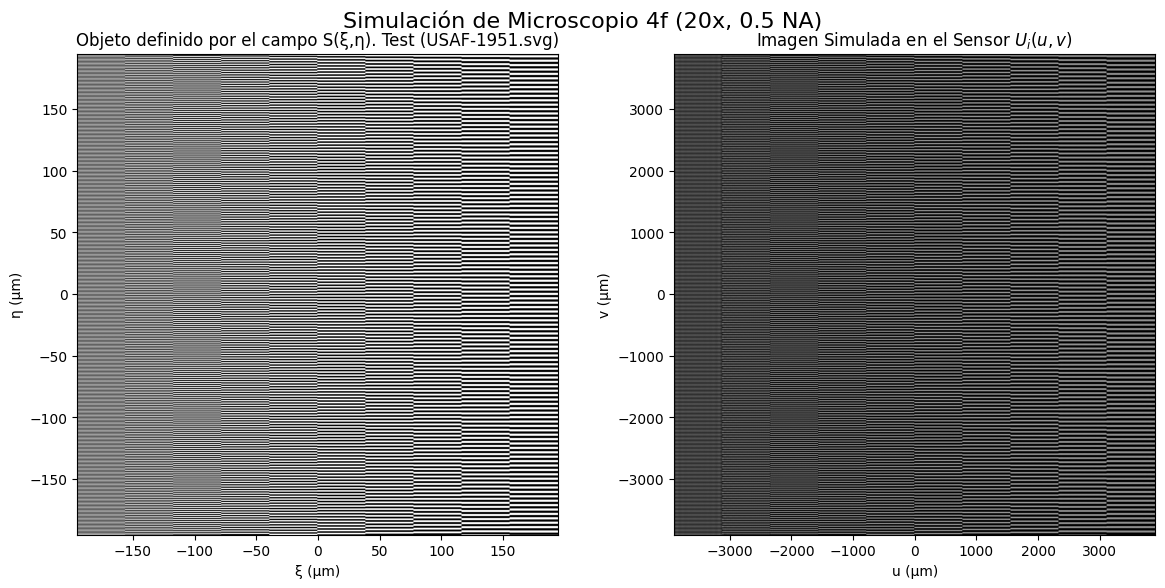

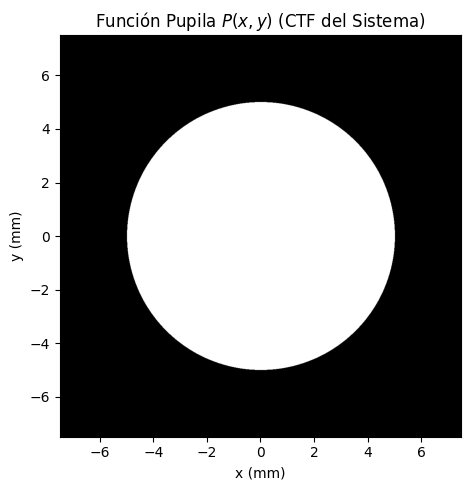

In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import io

try:
    import cairosvg
except ImportError:
    cairosvg = None
except Exception as e:
    cairosvg = None


def load_transmittance(image_path, N, obj_type='amplitud'):
    """
    Carga un archivo de imagen (PNG, JPG, SVG) y lo convierte en un campo complejo.
    """
    try:
        base_dir = os.path.dirname(os.path.abspath(__file__))
        absolute_path = os.path.join(base_dir, image_path)
    except NameError:
        absolute_path = image_path

    _, ext = os.path.splitext(image_path)

    # Si el archivo no se encuentra, el programa fallará con FileNotFoundError.
    if ext.lower() == '.svg':
        if cairosvg is None:
            raise ImportError("La biblioteca 'cairosvg' es necesaria para cargar archivos SVG. Instálala con: pip install cairosvg")

        png_data = cairosvg.svg2png(url=absolute_path, output_width=N, output_height=N, background_color="white")
        img_buffer = io.BytesIO(png_data)
        img = Image.open(img_buffer).convert('L')

    else:
        img = Image.open(absolute_path).convert('L')
        img = img.resize((N, N))

    # Convertir a arreglo numpy y normalizar [0,1]
    # Tendrá 0.0 para barras negras y 1.0 para fondo blanco.
    A = np.array(img, dtype=float) / 255.0

    if ext.lower() == '.svg':
        # Los SVG rasterizados con fondo blanco (1.0) y objeto negro (0.0)
        pass

    # Definir tipo de modulación
    if obj_type == 'amplitud':
        # Simula un objeto de campo claro (barras opacas=0.0, fondo transparente=1.0)
        t_xy = A.astype(np.complex128)
    elif obj_type == 'fase':
        phase = 2*np.pi * A
        t_xy = np.exp(1j * phase)
    else:
        raise ValueError("tipo debe ser 'amplitud' o 'fase'")

    return t_xy

def generate_line_test(pixel_count, dx_sensor, magnification,
                       num_groups=10, base_group=4):
    """
    Genera una imagen NxN (N = pixel_count) con 'num_groups' grupos de líneas
    HORIZONTALES binarias.

    Grupo k en la imagen (k = 1..num_groups) representa el grupo físico:
        g_fisico = base_group + (k-1)

    Para cada g_fisico:
        - ancho de línea = g_fisico píxeles
        - separación (espacio) = g_fisico píxeles
        -> periodo = 2*g_fisico píxeles

    0.0 = líneas (negro)
    1.0 = fondo (blanco)
    """

    N = pixel_count
    pattern = np.ones((N, N), dtype=float)  # fondo blanco

    # Tamaño físico de pixel en el objeto (como en tu simulación)
    dx_obj = dx_sensor / magnification  # [m/pixel]

    # Dividimos la imagen en bandas verticales: una por grupo
    group_width = N // num_groups

    y = np.arange(N)

    for k in range(1, num_groups + 1):
        # Grupo físico que estamos representando
        g_fisico = base_group + (k - 1)

        # Índices de columnas para este grupo
        col_start = (k - 1) * group_width
        col_end = N if k == num_groups else k * group_width  # el último grupo toma lo que quede

        # Periodo y ancho de línea en píxeles
        line_width_pix = g_fisico
        period_pix = 2 * line_width_pix  # línea + espacio

        # Patrón 1D de líneas horizontales (True donde hay línea)
        local_y = y % period_pix
        lines_mask = (local_y < line_width_pix)  # array bool de tamaño N

        # Aplicar el patrón horizontal a TODAS las columnas del grupo
        # (todas las columnas del grupo comparten las mismas líneas horizontales)
        pattern[lines_mask, col_start:col_end] = 0.0

        # Info física para que sepas qué estás metiendo
        period_m = period_pix * dx_obj              # periodo en el objeto [m]
        period_um = period_m * 1e6                  # [µm]
        freq_lpmm = 1e3 / period_um                 # líneas por mm (ciclos/mm)
        print(f"Grupo imagen {k} (g_fisico={g_fisico}): "
              f"periodo = {period_um:.3f} µm, f ≈ {freq_lpmm:.1f} lp/mm")

    # Devolvemos como campo complejo (amplitud) para usar directo en la simulación
    t_xy = pattern.astype(np.complex128)
    return t_xy







def create_pupil_mask(pixel_count, pupil_plane_size_m, pupil_radius_m):
    """
    Crea la Función de Transferencia Coherente (CTF), que es la pupila
    del objetivo MO.

    Args:
        pixel_count (int): Número de píxeles (N) en un lado.
        pupil_plane_size_m (float): Tamaño físico total de la cuadrícula de la pupila [m].
        pupil_radius_m (float): Radio físico de la pupila [m].

    Returns:
        np.ndarray: Arreglo 2D (NxN) de la pupila (0.0+0j o 1.0+0j).
    """
    # Crear la rejilla de coordenadas de la pupila
    pupil_coords = np.linspace(-pupil_plane_size_m/2, pupil_plane_size_m/2, pixel_count)
    X_p, Y_p = np.meshgrid(pupil_coords, pupil_coords)

    # Calcular la distancia radial de cada píxel al centro
    R_p_grid = np.sqrt(X_p**2 + Y_p**2)

    # Crear la apertura: 1.0 adentro del radio, 0.0 afuera
    pupil_function = np.zeros((pixel_count, pixel_count), dtype=complex)
    pupil_function[R_p_grid < pupil_radius_m] = 1.0 + 0.0j

    return pupil_function

# SECCIÓN 2: FUNCIÓN DE SIMULACIÓN

def simulate_system(input_object, object_size_m, pixel_count, wavelength, f_MO, f_TL, pupil_radius_m):
    """
    Simula la formación de imagen en un sistema 4f (microscopio).

    Implementa la Teoría de Abbe:
    Imagen = IFFT( FFT(Objeto) * Pupila )
    Ref: S20 - Formación de imágenes en microscopía
    """

    # 1. Calcular la escala del plano de la pupila (Plano de Fourier)
    dx_object = object_size_m / pixel_count
    pupil_plane_size_m = (wavelength * f_MO) / dx_object

    # 2. Crear la pupila (el filtro en el plano de Fourier)
    pupil_function = create_pupil_mask(pixel_count, pupil_plane_size_m, pupil_radius_m)

    # 3. Simular la propagación y el filtrado (con el 'shift' correcto)

    # Etapa 1: Objeto -> Plano Focal (Pupila)
    # Mover el origen (0,0) del centro a la esquina para la FFT.
    object_spectrum = np.fft.fft2(np.fft.ifftshift(input_object))

    # Etapa 2: Filtrado Espacial
    # Multiplicar el espectro (origen en esquina) por la pupila (origen movido a esquina).
    filtered_spectrum = object_spectrum * np.fft.fftshift(pupil_function)

    # Etapa 3: Plano Focal (Pupila) -> Plano Imagen (Cámara)
    # Mover el origen (0,0) de la imagen resultante de la esquina de vuelta al centro.
    output_field = np.fft.fftshift(np.fft.ifft2(filtered_spectrum))

    # 4. Calcular magnificación y escala de la imagen final
    magnification = f_TL / f_MO
    image_plane_size_m = object_size_m * magnification

    # Devolvemos la pupila y su escala para poder graficarla
    return output_field, image_plane_size_m, pupil_function, pupil_plane_size_m



# --- 1. Parámetros del Sistema Físico (de la Entrega 03) ---
wavelength = 533e-9      # Longitud de onda (533 nm)
f_mo = 0.01              # Focal Objetivo (10 mm, calculado f_TL/mag)
f_tl = 0.2               # Focal Lente de Tubo (200 mm)
na_mo = 0.5              # Apertura Numérica del objetivo (0.5)

magnification = f_tl / f_mo # Magnificación (20x)

# --- 2. Parámetros del Sensor (Detector) ---
# Alvium 1800 U-811m
dx_sensor = 2.74e-6 # pixel size (2.74 µm)
pixel_count = 2848  # N
sensor_size_m = pixel_count * dx_sensor

# --- 3. Cargar el Objeto de Prueba ---
# El tamaño físico del objeto debe ser el del sensor dividido por la magnificación
object_size_m = sensor_size_m / magnification # (aprox 390 µm)

filename = 'USAF-1951.svg'
#U0 = load_transmittance(filename, pixel_count, obj_type='amplitud')
U0 = generate_line_test(pixel_count, dx_sensor, magnification,
                        num_groups=10, base_group=4)

# --- 4. Calcular Radio de la Pupila Físico ---
pupil_radius_m = na_mo * f_mo

# --- 5. Simular el Microscopio 4f ---
output_field, image_plane_size_m, pupil_mask, pupil_plane_size_m = simulate_system(
    U0, object_size_m, pixel_count, wavelength, f_mo, f_tl, pupil_radius_m
)

# --- 6. Detección de la Imagen (Intensidad) ---
intensity = np.abs(output_field)**2
intensity = intensity / np.max(intensity)


# SECCIÓN 4: VISUALIZACIÓN DE RESULTADOS

# Guardar imágenes generadas
output_dir = "output_imagenes_campo_claro"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# --- (NUEVO) Definir la extensión del objeto primero ---
extent_obj_um = [-object_size_m/2 * 1e6, object_size_m/2 * 1e6, -object_size_m/2 * 1e6, object_size_m/2 * 1e6]

#Figura 1: Guardar solo el Objeto Original ---
plt.figure(figsize=(6, 5)) # Tamaño cuadrado para la imagen
plt.imshow(np.abs(U0), cmap='gray', extent=extent_obj_um)
plt.title(f'Objeto definido por el campo S(ξ,η). Test ({filename})')
plt.xlabel('ξ (μm)')
plt.ylabel('η (μm)')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "fig0_objeto_original.png"), dpi=300)
plt.close() # Cerrar la figura para que no se muestre


plt.figure(figsize=(12, 6))
plt.suptitle(f"Simulación de Microscopio 4f ({magnification:.0f}x, {na_mo} NA)", fontsize=16)

# --- Figura 1: Objeto Original ---
# Convertir tamaño a micras para los ejes
extent_obj_um = [-object_size_m/2 * 1e6, object_size_m/2 * 1e6, -object_size_m/2 * 1e6, object_size_m/2 * 1e6]
plt.subplot(1, 2, 1)
# Usamos 'origin'='lower' para que el (0,0) esté abajo a la izquierda.
plt.imshow(np.abs(U0), cmap='gray', extent=extent_obj_um)
plt.title(f'Objeto definido por el campo S(ξ,η). Test ({filename})')
plt.xlabel('ξ (μm)')
plt.ylabel('η (μm)')



# --- Figura 2: Imagen en el sensor
# Convertir tamaño a micras para los ejes
extent_cam_um = [-image_plane_size_m/2 * 1e6, image_plane_size_m/2 * 1e6, -image_plane_size_m/2 * 1e6, image_plane_size_m/2 * 1e6]
plt.subplot(1, 2, 2)
plt.imshow(intensity, cmap='gray', extent=extent_cam_um)
plt.title('Imagen Simulada en el Sensor $U_i(u,v)$')
plt.xlabel('u (μm)')
plt.ylabel('v (μm)')

plt.tight_layout(rect=[0, 0.04, 1, 1])
# --- Guardar la figura 2 ---
plt.savefig(os.path.join(output_dir, "fig1_objeto_e_imagen_combinados.png"), dpi=300)
plt.show()

# --- Figura 3: Pupila ---
plt.figure(figsize=(6, 5))
# Convertir tamaño a milímetros para los ejes
extent_pup_mm = [-pupil_plane_size_m/2 * 1000, pupil_plane_size_m/2 * 1000, -pupil_plane_size_m/2 * 1000, pupil_plane_size_m/2 * 1000]
zoom_limit_mm = pupil_radius_m * 1.5 * 1000 # Zoom 1.5x el radio de la pupila
plt.imshow(np.abs(pupil_mask), cmap='gray', extent=extent_pup_mm)
plt.title('Función Pupila $P(x,y)$ (CTF del Sistema)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.xlim(-zoom_limit_mm, zoom_limit_mm)
plt.ylim(-zoom_limit_mm, zoom_limit_mm)
plt.tight_layout()
# --- Guardar la figura 3 ---
plt.savefig(os.path.join(output_dir, "fig2_pupila.png"), dpi=300)
plt.show()